### 这个代码用来拟合cos函数

In [34]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D 
from matplotlib import cm
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import StepLR

In [35]:
# 选择设备
# GPU usage #########################################
# dtype = torch.FloatTensor # uncomment if you are using CPU
dtype = torch.cuda.FloatTensor # uncomment if you are using GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

#### 准备数据集

In [36]:
t_data = np.random.uniform(0, 10, (10000, 1))
A = 1
f_data = A*np.cos(2 * np.pi * t_data)

In [37]:
pt_t_data = torch.from_numpy(t_data).float().to(device)
pt_f_data = torch.from_numpy(f_data).float().to(device)

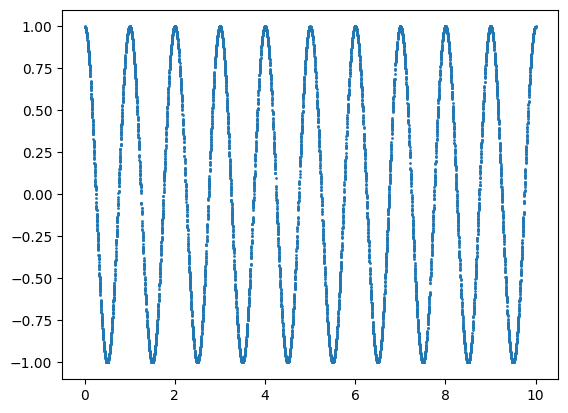

In [38]:
plt.scatter(t_data, f_data, s=1)
plt.show()

#### 构建网络

In [39]:
class fitting(nn.Module):
    def __init__(self, N_iput_dim=1, N_hidden_dim=64, N_hidden_layers=4):
        super().__init__()
        self.input = nn.Linear(N_iput_dim, N_hidden_dim).to(device)
        self.hidden = nn.ModuleList([nn.Linear(N_hidden_dim, N_hidden_dim).to(device) for _ in range(N_hidden_layers)])
        self.output = nn.Linear(N_hidden_dim, 1).to(device)
        self.activation = nn.Tanh()

    def forward(self, x):
        x = self.activation(self.input(x))
        for layer in self.hidden:
            x = self.activation(layer(x))
        x = self.output(x)

        return x

In [40]:
fit_net = fitting()
mse_cost_function = torch.nn.MSELoss() # Mean squared error
optimizer = torch.optim.Adam(fit_net.parameters(), lr=0.001)
scheduler = StepLR(optimizer, step_size=50000, gamma=0.1)   # 每N步学习率乘以0.1

In [41]:
fit_net.train()
iterations = 200000
for epoch in range(iterations):
    f_out = fit_net(pt_t_data)

    loss = mse_cost_function(f_out, pt_f_data)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    scheduler.step()

    if epoch%10000 == 0:
    	print(epoch,"Traning Loss:",loss.item())
    

0 Traning Loss: 0.5049222707748413
10000 Traning Loss: 0.10643625259399414
20000 Traning Loss: 7.595580973429605e-05
30000 Traning Loss: 0.0004210893530398607
40000 Traning Loss: 2.6598447220749222e-05
50000 Traning Loss: 0.0002839567023329437
60000 Traning Loss: 8.646396054245997e-06
70000 Traning Loss: 3.7444665395014454e-06
80000 Traning Loss: 3.4104275528079597e-06
90000 Traning Loss: 6.934012162673753e-06
100000 Traning Loss: 1.5765270291012712e-05
110000 Traning Loss: 1.5221270359688788e-06
120000 Traning Loss: 1.309990352638124e-06
130000 Traning Loss: 1.1256597645115107e-06
140000 Traning Loss: 1.1404534916437115e-06
150000 Traning Loss: 8.992308266897453e-07
160000 Traning Loss: 8.302027367790288e-07
170000 Traning Loss: 7.60886450734688e-07
180000 Traning Loss: 7.008111992945487e-07
190000 Traning Loss: 6.482861181211774e-07


In [48]:
t_p = np.linspace(0, 10, 1000)[:, None]
f_p = A*np.cos(2 * np.pi * t_p)
pt_t_p = torch.from_numpy(t_p).float().to(device)
# pt_f_p = torch.from_numpy(f_p).float().to(device)
f_out = fit_net(pt_t_p)
f_out1 = f_out.data.cpu().numpy()

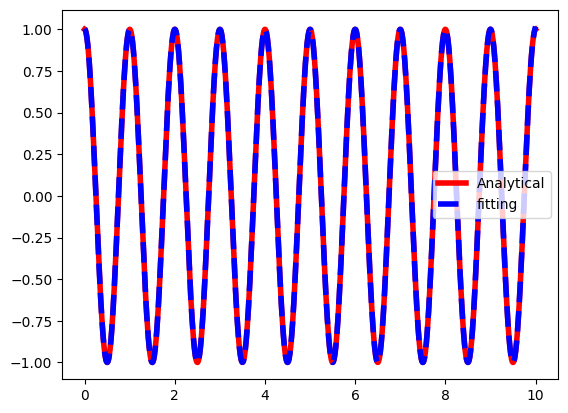

In [49]:
plt.plot(t_p, f_p, c='r', label='Analytical', linewidth=4)
plt.plot(t_p, f_out1, c='b', label='fitting', linestyle='--', linewidth=4)
plt.legend()
plt.show()